- 선긋기
- 보스턴 주요피쳐 의사결정트리로 찾기

# 과제 1. 선긋기

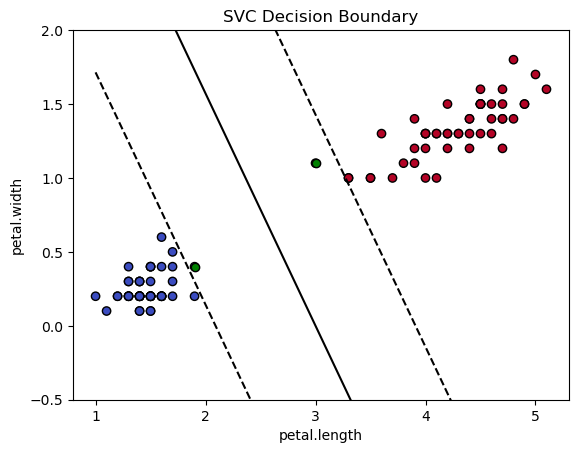

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split # 분리
from sklearn.svm import SVC

# 데이터 불러오기
irisDF = pd.read_csv("../data/iris.csv", usecols=[2, 3, 4])
irisDF = irisDF[irisDF["variety"].isin(['Setosa', 'Versicolor'])] # 종 거르기 

featureDF = irisDF.iloc[:,[0, 1]] # feature는 2개
targetSR = irisDF.iloc[:,-1] # target은 종
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetSR, test_size=0.3, stratify=targetSR, random_state=42)

X = np.array(featureDF)
y = targetSR.T.replace({"Setosa":0, "Versicolor":1}) # 데이터 이진화 해주기 -> sklearn에서는 안해도 무관

# SVC 모델 생성
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

# 결정 경계 그리기
w = svc_model.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(X[:, 0].min(), X[:, 0].max()) # 그래프용, 수식 대압용
yy = a * xx - (svc_model.intercept_[0]) / w[1]

# Support vectors
margin = 1 / np.sqrt(np.sum(svc_model.coef_ ** 2)) #분산 
yy_down = yy - np.sqrt(1 + a ** 2) * margin
yy_up = yy + np.sqrt(1 + a ** 2) * margin

plt.plot(xx, yy, 'k-')
plt.plot(xx, yy_down, 'k--') # 점선
plt.plot(xx, yy_up, 'k--') # 점선 

# Scatter plot
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
plt.scatter(svc_model.support_vectors_[:, 0],svc_model.support_vectors_[:, 1], color="green", edgecolors='k')

plt.ylim(-0.5,2)
plt.xlabel('petal.length')
plt.ylabel('petal.width')
plt.title('SVC Decision Boundary')
plt.show()

# 과제 2. 보스턴 주요피쳐 의사결정트리로 찾기

# House 데이터 교차검증
- target : MEDV

crim  
마을별 1인당 범죄  

  
zn
25,000평방피트 이상의 부지에 대해 구역이 지정된 주거용 토지의 비
  니다.

  
indus
도시별 비소매업   면적의 비율.

__chas__
찰스 강 더미 변수(지역이 강을 경계로 하는 경우 1, 그렇지 않으면 0).

nox
질소 산화물 농도(천만 개당 부품).

rm
주거지당 평균 방 수입니다.

age
1940년 이전에 지어진 소유주가 거주하는 유닛의 비율입니다.

dis
보스턴의 5개 고용 센터까지의 거리의 가중 평균.

__rad__
방사형 고속도로에 대한 접근성 지수.

tax
10,000달러당 전체 가치의 재산세율.

ptratio
도시별 학생 대 교사 비율입니다.

black
1000(Bk - 0.63)^2 여기서 Bk는 도시별 흑인 비율입니다.

lstat
인구의 하위 상태(백분율)입니다.

medv
소유주가 거주하는 주택의 중간값($1000대).


## 모듈 로딩 및 데이터 준비

In [234]:
houseDF = pd.read_csv("../data/HousingData.csv")

houseDF.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [235]:
houseDF.info() # 결측치 있음!! -> 중앙값으로 대체하기 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [236]:
# 형변환
for col_name in houseDF.columns:
    if len(houseDF[col_name].unique())<10:
        houseDF[col_name] = houseDF[col_name].astype("object")

In [237]:
houseDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     486 non-null    float64
 1   ZN       486 non-null    float64
 2   INDUS    486 non-null    float64
 3   CHAS     486 non-null    object 
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      486 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    object 
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    486 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(1), object(2)
memory usage: 55.5+ KB


In [238]:
houseDF.describe() # 정규화 시켜주기 

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.554695,6.284634,68.518519,3.795043,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.115878,0.702617,27.999513,2.105710,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.385000,3.561000,2.900000,1.129600,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.449000,5.885500,45.175000,2.100175,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.538000,6.208500,76.800000,3.207450,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.624000,6.623500,93.975000,5.188425,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,0.871000,8.780000,100.000000,12.126500,711.000000,22.000000,396.900000,37.970000,50.000000


In [239]:
import seaborn as sns
import matplotlib.pyplot as plt # 그래프

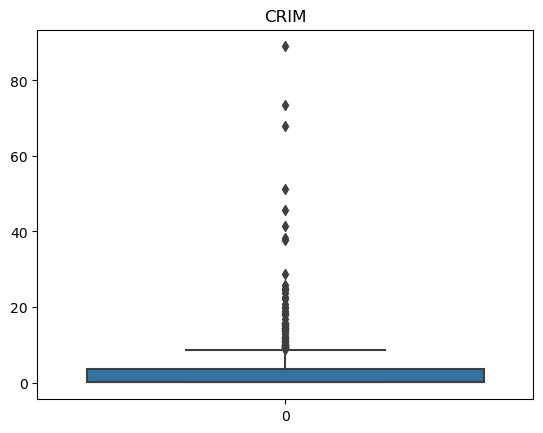

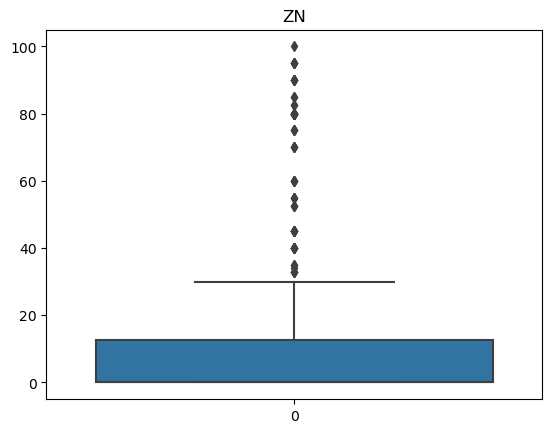

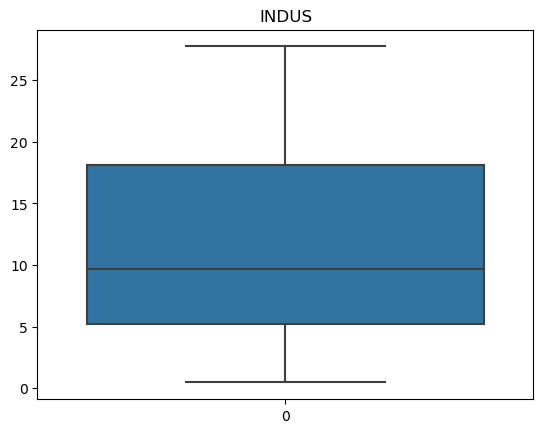

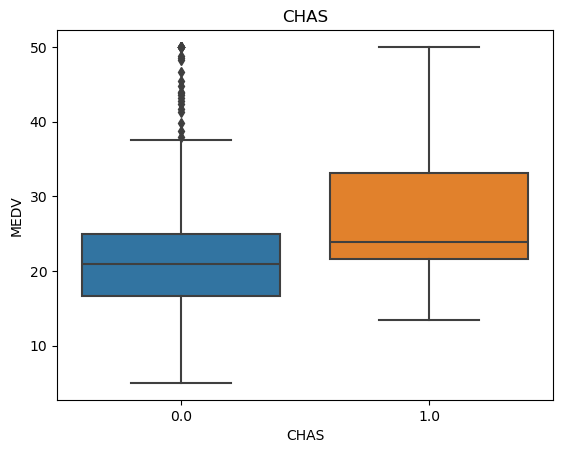

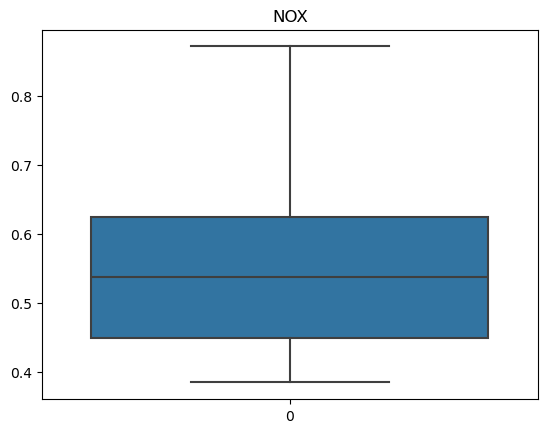

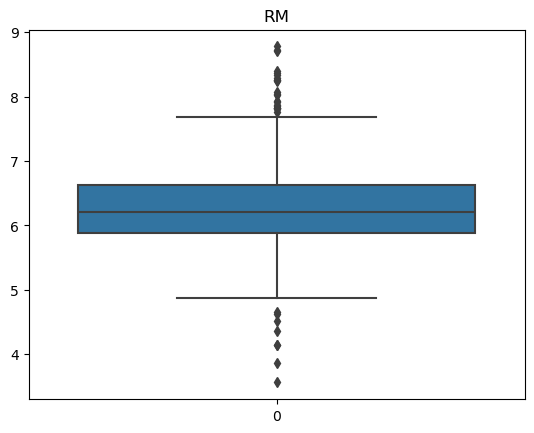

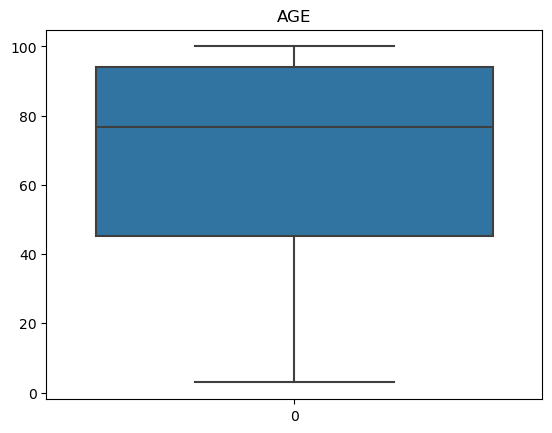

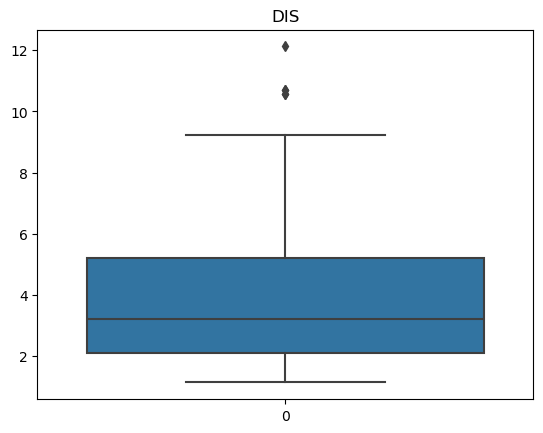

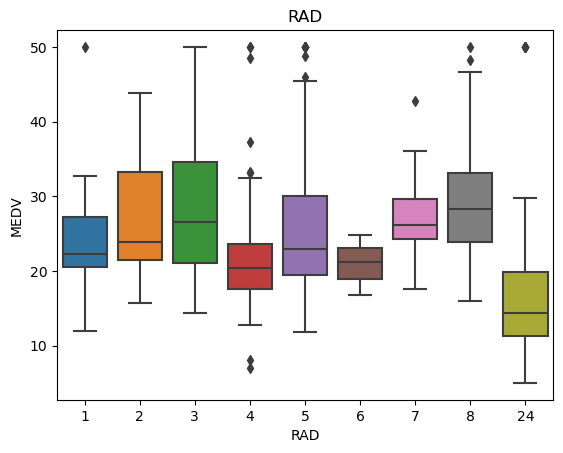

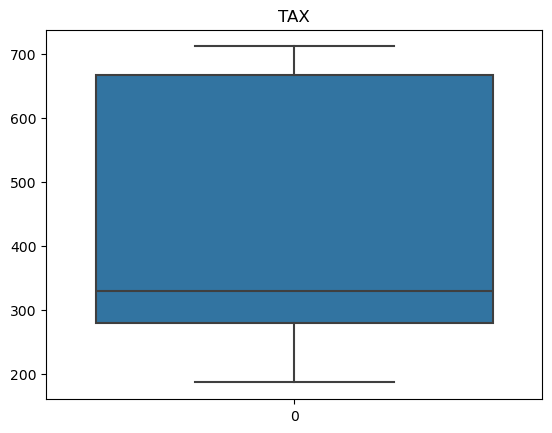

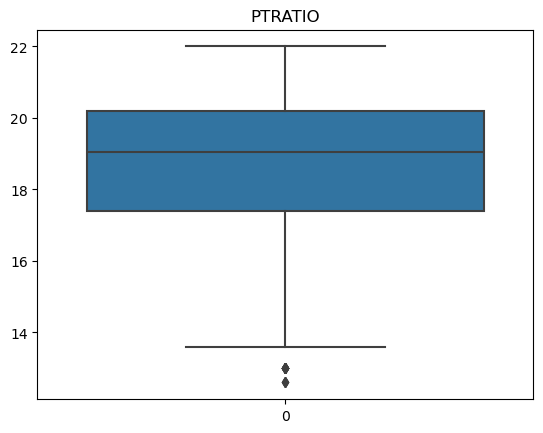

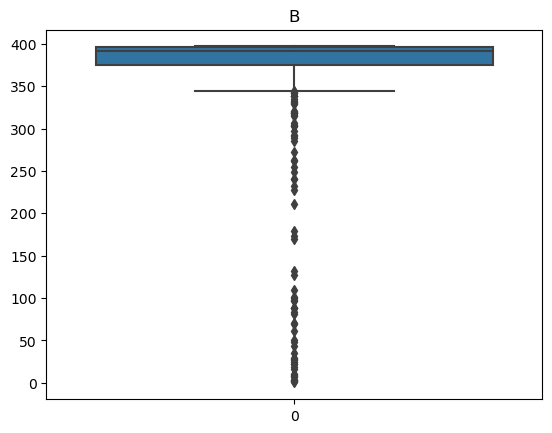

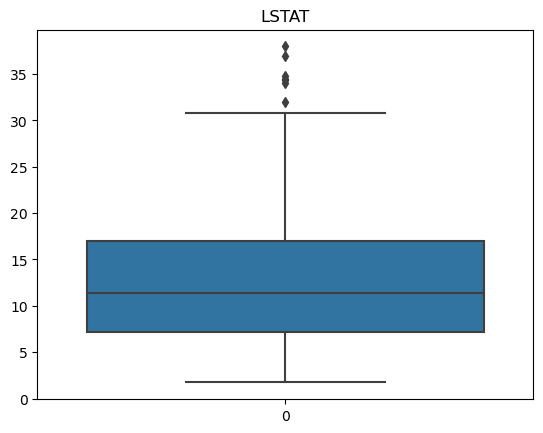

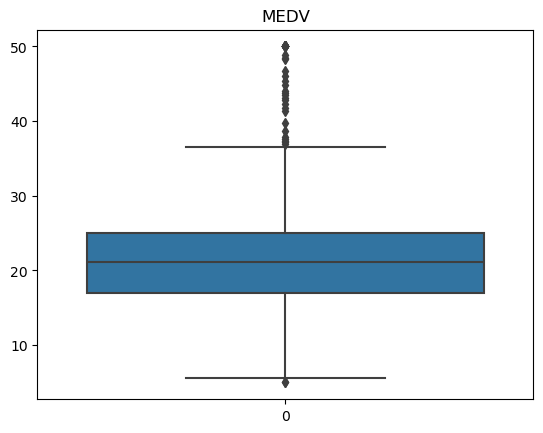

In [240]:
for col_name in houseDF.columns:
    if houseDF[col_name].dtype == "catego" or len(houseDF[col_name].unique())<10:
        sns.boxplot(x = col_name, y="MEDV", data=houseDF)
        plt.title(col_name)
        plt.show()
    else:
        sns.boxplot(houseDF[col_name])
        plt.title(col_name)
        plt.show()

In [241]:
## 2. 데이터 준비 => 피쳐 & 타겟 분리

featureDF = houseDF.iloc[:,:-1]

TargetSR = houseDF.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(featureDF, TargetSR, test_size=0.3, random_state=5)

In [242]:
X_train.shape, y_train.shape

((354, 13), (354,))

In [243]:
X_test.shape, y_test.shape

((152, 13), (152,))

In [244]:
# 전처리 과정, 결측치 -> 중앙값으로 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder # 카테고리를 텍스트에서 숫자로 


num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent") # 최빈값으로 대체
    # OrdinalEncoder(handle_unknown="use_encoded_value") # 숫자값으로 인코딩
)

In [245]:
num_attribs = []
cat_attribs = []
for col_name in featureDF.columns:
    if featureDF[col_name].dtype != "object":
        num_attribs.append(col_name)
    else:
        cat_attribs.append(col_name)

In [246]:
num_attribs

['CRIM',
 'ZN',
 'INDUS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [247]:
cat_attribs

['CHAS', 'RAD']

In [248]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs), # 위에서 생성한 파이프라인 -> 수치형 데이터를 위함
    ("cat", cat_pipeline, cat_attribs) # 해당 셀에서 생성한 파이프라인 -> 범주형 데이터를 위함
])

In [249]:
preprocessing.fit_transform(featureDF)

array([[-0.4055915623276797, 0.3143688355518804, -1.3017060313164523,
        ..., -1.0961934464725756, 0.0, 1],
       [-0.40314013499315987, -0.46815954766936224, -0.5910515354264776,
        ..., -0.5027793201469953, 0.0, 2],
       [-0.4031424707981475, -0.46815954766936224, -0.5910515354264776,
        ..., -1.2317086916671194, 0.0, 2],
       ...,
       [-0.39923350115134526, -0.46815954766936224, 0.13453267676370662,
        ..., -1.002046012968998, 0.0, 1],
       [-0.3935306332740416, -0.46815954766936224, 0.13453267676370662,
        ..., -0.8822220066917174, 0.0, 1],
       [-0.40079265098058964, -0.46815954766936224, 0.13453267676370662,
        ..., -0.6825153295629164, 0.0, 1]], dtype=object)

In [250]:
X_train.shape

(354, 13)

In [251]:
X_train = pd.DataFrame(preprocessing.fit_transform(X_train), columns=num_attribs+cat_attribs)
X_train

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,CHAS,RAD
0,0.887818,-0.471409,1.11341,1.645428,0.233772,0.970484,-0.900522,1.538813,0.810913,-3.46382,1.641435,0.0,24
1,0.48642,-0.471409,1.11341,1.113435,-0.149715,0.368692,-0.926152,1.538813,0.810913,-2.872888,1.289177,0.0,24
2,0.28492,-0.471409,1.11341,-0.16858,0.653301,0.253378,-0.241993,1.538813,0.810913,0.389957,-0.68404,0.0,24
3,-0.406822,3.550842,-1.456178,-1.293614,1.372699,-1.656502,2.387078,-1.061095,-0.265106,0.421447,-1.103599,0.0,5
4,-0.39009,-0.471409,2.580876,0.502952,-1.215116,0.89481,-0.982361,1.804713,0.764129,0.412198,0.793725,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.282925,-0.471409,1.11341,0.276201,-0.263608,0.429952,-0.137024,1.538813,0.810913,0.385663,0.352687,0.0,24
350,-0.398248,1.539717,-1.118235,-0.997094,1.280432,-1.043899,0.363219,-0.044767,-1.528259,0.432127,-1.020546,0.0,5
351,-0.386673,-0.471409,-0.166817,0.293643,-0.903713,-1.407857,-0.503239,-0.086129,0.343078,0.392379,0.727856,0.0,6
352,-0.380515,-0.471409,-0.029813,-0.543592,0.042029,-0.553816,0.259426,-0.759742,0.062378,0.409776,-0.221522,0.0,4


In [252]:
X_test = preprocessing.transform(X_test)
X_test

array([[-0.36199820457348647, -0.4714088297462333, -0.6980888051569171,
        ..., -0.18572374581062412, 0.0, 8],
       [-0.40402331117727047, 3.103925411928466, -0.3388335976095656,
        ..., -1.1193502284315795, 0.0, 4],
       [-0.40272486789973516, -0.4714088297462333, -1.1228015293336586,
        ..., -0.5308218781904558, 0.0, 2],
       ...,
       [-0.4005603908926557, 2.657008631719129, -1.3009068652787439, ...,
        -1.0806877820653742, 0.0, 5],
       [-0.3780726651299904, -0.4714088297462333, 1.6903494179015335,
        ..., 1.2605381367770518, 0.0, 4],
       [0.38580552333480234, -0.4714088297462333, 1.1134099108657447,
        ..., -1.3685082161249018, 1.0, 24]], dtype=object)

In [253]:
from sklearn.tree import DecisionTreeRegressor # 의사결정트리

In [259]:
for i in range(2, 20):
    tree_reg = DecisionTreeRegressor(max_depth=i, random_state=42)
    tree_reg.fit(X_train, y_train)
    print(f"\n\n====={i}=====")
    print(tree_reg.score(X_train, y_train))
    print(tree_reg.score(X_test, y_test))



=====2=====
0.6932891740809815
0.694843024497416


=====3=====
0.8023692724322393
0.7403860782660221


=====4=====
0.8729494168060709
0.71740647905832


=====5=====
0.909654857642731
0.8371654377235103


=====6=====
0.9387104487007586
0.8274242345008237


=====7=====
0.9626606894527487
0.802091089290093


=====8=====
0.9762419852032265
0.714805223513733


=====9=====
0.9829082916167652
0.7852500996836933


=====10=====
0.9877521490824278
0.7149736743596833


=====11=====
0.9906721847411002
0.6864709803950837


=====12=====
0.9930581894365572
0.7722194523991932


=====13=====
0.9950642883986065
0.6975392393934323


=====14=====
0.9967481676643419
0.7905164007864197


=====15=====
0.9980876504467748
0.712462008926491


=====16=====
0.9993044584784512
0.7768733854825749


=====17=====
0.9997979183906418
0.7783007951845748


=====18=====
0.999939672479224
0.793432046489863


=====19=====
0.9999900928411629
0.6966746257321588


C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\k

In [261]:
tree_reg = DecisionTreeRegressor(max_depth=6, random_state=42)
tree_reg.fit(X_train, y_train)
print(tree_reg.score(X_train, y_train))
print(tree_reg.score(X_test, y_test))

0.9387104487007586
0.8274242345008237


C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [262]:
tree_reg.score(X_train, y_train)

0.9387104487007586

In [263]:
tree_reg.score(X_test, y_test)

C:\Users\kdp\anaconda3\envs\EXAM_ML\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


0.8274242345008237

뭘 학습한거야ㅠㅠ

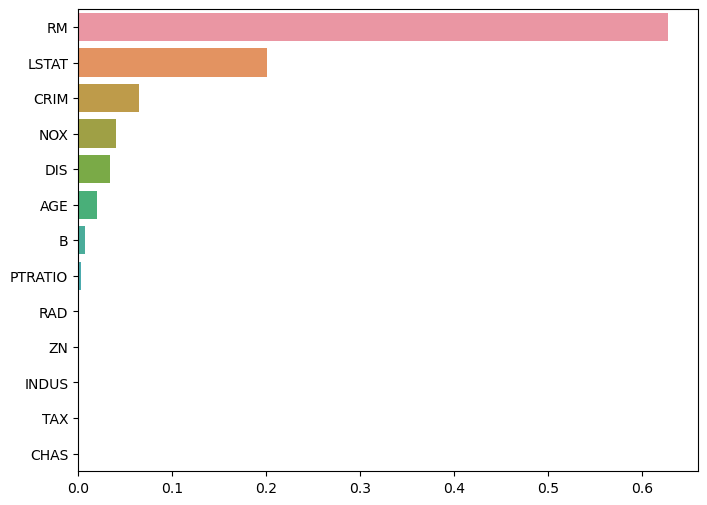

In [257]:
import seaborn as sns
feature_importance_values = tree_reg.feature_importances_

feature_importances = pd.Series(feature_importance_values, index=X_train.columns)

sorted_feature = feature_importances.sort_values(ascending=False)
 
plt.figure(figsize=[8, 6])
sns.barplot(x=sorted_feature, y=sorted_feature.index)
plt.show()

rm
주거지당 평균 방 수입니다.

lstat
인구의 하위 상태(백분율)입니다.
